In [2]:
!pip install tikzplotlib

     |████████████████████████████████| 54 kB 2.0 MB/s 


In [3]:
!pip install graphviz==0.17

  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
!pip install --upgrade openpyxl

In [53]:
!pip install --upgrade pandas

In [5]:
import graphviz

In [6]:
# !pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install numpyro[cuda112] -f https://storage.googleapis.com/jax-releases/jax_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 283 kB 6.3 MB/s 


In [9]:
!pip install funsor #B/c i've got discrete latent variables 

     |████████████████████████████████| 174 kB 8.7 MB/s 


In [10]:
import re

In [11]:
import os
import glob
import arviz as az
import xarray as xr


from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp, logit, expit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import sample
from numpyro.distributions import (Categorical, ImproperUniform, Normal, OrderedLogistic,
                                   TransformedDistribution, constraints, transforms)
from numpyro import handlers
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS
from numpyro.infer import HMC, SA, Predictive, log_likelihood

from numpyro import handlers
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

import jax
from jax.scipy import stats
import tensorflow_probability as tfp
import tikzplotlib
import statsmodels.api as sm
import scipy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Loading

Loading all the different datasets of interest we are using in this work up front. The column names are not consistent across the documents, so we will re-name the columns to standardized values so that they merge nicely. The `df` data frame is for the ML data, and the other sciences are postpended with the area they are from. 
 
 

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!cp -r ./drive/MyDrive/Colab\ Notebooks/ReproductionCitation/camera_ready/* ./

In [63]:
col_renames = {'Replicate (R)' : 'Replicated', 
               'Replicated': 'Replicated', "Reproduced": 'Replicated',
               'Journal (O)' : 'Journal', 
               'Study Title (O)': 'Study', "Paper" : 'Study',
               'Authors': 'Study'}

df = pd.read_csv("ml_blind.csv")
df_psych = pd.read_csv("rpp_data_with_citation_counts.csv")
df_psych.rename(columns=col_renames, inplace=True)
df_psych = df_psych[['Study Num', 'SemanticScholarID', 'Study', 'Year', 'Journal', 'Replicated' ] + [str(i)+"_YearsLater" for i in range(12)]]
df_psych['Field'] = 'Psychology'
df_psych['Replicated'] = df_psych['Replicated'].apply(lambda x: ['no', 'yes'].index(x.lower()))
df_econ = pd.read_csv("Camerer2016_EconRepro_with_citation_counts.csv")
df_econ.rename(columns=col_renames, inplace=True)
df_econ = df_econ[['Study Num','SemanticScholarID', 'Study', 'Year', 'Journal', 'Replicated'  ] + [str(i)+"_YearsLater" for i in range(12)]]
df_econ['Field'] = 'Economics'
df_soci = pd.read_csv("Camerer2018_SocialScienceRepro_with_citation_counts.csv")
df_soci.rename(columns=col_renames, inplace=True)
df_soci = df_soci[['Study Num','SemanticScholarID', 'Study', 'Year', 'Journal', 'Replicated' ] + [str(i)+"_YearsLater" for i in range(12)]]
df_soci['Field'] = 'Nature/Science'
df_med = pd.read_csv("Ioannidis2005_MedRepro_with_citation_counts.csv")
df_med.rename(columns=col_renames, inplace=True)
df_med = df_med[['SemanticScholarID', 'Study', 'Year', 'Journal', 'Replicated' ] + [str(i)+"_YearsLater" for i in range(12)]]
df_med['Field'] = 'Medicine'


Since I'm using Numpyro for the model and it works on numpy arrays, I'm pulling out all of the variables I want for the ML model and processing them accordingly. 

In [65]:
citation_count = df[["0_YearsLater","1_YearsLater", "2_YearsLater", "3_YearsLater", "4_YearsLater", "5_YearsLater", "6_YearsLater", "7_YearsLater", "8_YearsLater", "9_YearsLater"]].to_numpy()
year_published = df['Year'].to_numpy().astype(np.int32)
code_available = df['Author Code Available'].apply(lambda x: ['No', 'Yes'].index(x)).to_numpy()
reproduced = df['Reproduced'].apply(lambda x: ['No', 'Yes'].index(x)).to_numpy()
theory = (df['Rigor vs Empirical'] == 'Theory').to_numpy()
empirical =(df['Rigor vs Empirical'] == 'Empirical').to_numpy()
balanced = (df['Rigor vs Empirical'] == 'Balance').to_numpy()
tfpg = df[["Normalized Num References", "Normalized Number of Equations", "Normalized Number of Proofs", "Normalized Total Tables and Figures", "Normalized Number of Tables", "Normalized Number of Graphs/Plots", "Normalized Number of Other Figures", "Normalized Conceptualization Figures"]].to_numpy()
tfp_names = ["Num References", "Number of Equations", "Number of Proofs", "Total Tables and Figures", "Number of Tables", "Number of Graphs/Plots", "Number of Other Figures", "Conceptualization Figures"]

In [66]:
all_types = sorted(df['Type'].unique().tolist())
types = df['Type'].apply(lambda x: all_types.index(x)).to_numpy()
all_topics = sorted(df['Primary Topic'].unique().tolist())
topic = df['Primary Topic'].apply(lambda x: all_topics.index(x)).to_numpy()
all_venues = sorted(df['Venue'].unique().tolist())


In [67]:
max_clusters = 50 #We need some limit for the DP

The Google Scholar citation data from prior work is in xlsx files per study, we need to grab each and extract the 8 years of data available to compare with. We also have to match up the study IDs with the original later. 

In [72]:
gs_df = {'Study Num': [], 'GS Cites': []}
for y in range(8):
  gs_df["GS_"+str(y)+"_YearsLater"] = []
# Add GS cites for econ
for tmp_f in glob.glob("PP_Econ/*xlsx"):
  study_gs = pd.read_excel(tmp_f).dropna(subset=['Year'])
  id = int(re.search(".*study_(\\d+).*xlsx",tmp_f).group(1))
  gs_df['Study Num'].append(id)
  gs_df['GS Cites'].append(np.sum(study_gs['Year'].to_numpy() > 0))
  year_ = df_econ[df_econ['Study Num'] == id]['Year'].to_numpy()[0]
  for y, cites in zip(range(8), [(study_gs['Year'].to_numpy() == year_+i).sum() for i in range(8)]):
    gs_df["GS_"+str(y)+"_YearsLater"].append(cites)
df_econ = df_econ.merge(pd.DataFrame(data=gs_df), left_on='Study Num', right_on='Study Num')

# Add GS cites for psych
gs_df = {'Study Num': [], 'GS Cites': []}
for y in range(8):
  gs_df["GS_"+str(y)+"_YearsLater"] = []
for tmp_f in glob.glob("PP_Psychology/*xlsx"):
  study_gs = pd.read_excel(tmp_f).dropna(subset=['Year'])
  id = int(re.search(".*study_(\\d+).*xlsx",tmp_f).group(1))
  gs_df['Study Num'].append(id)
  gs_df['GS Cites'].append(np.sum(study_gs['Year'].to_numpy() > 0))
  year_ = df_psych[df_psych['Study Num'] == id]['Year'].to_numpy()[0]
  for y, cites in zip(range(8), [(study_gs['Year'].to_numpy() == year_+i).sum() for i in range(8)]):
    gs_df["GS_"+str(y)+"_YearsLater"].append(cites)
df_psych = df_psych.merge(pd.DataFrame(data=gs_df), left_on='Study Num', right_on='Study Num')


# Add GS cites for soci
gs_df = {'Study Num': [], 'GS Cites': []}
for y in range(8):
  gs_df["GS_"+str(y)+"_YearsLater"] = []
for tmp_f in glob.glob("PP_NHB/*xlsx"):
  study_gs = pd.read_excel(tmp_f).dropna(subset=['Year'])
  id = int(re.search(".*study_(\\d+).*xlsx",tmp_f).group(1))
  gs_df['Study Num'].append(id)
  gs_df['GS Cites'].append(np.sum(study_gs['Year'].to_numpy() > 0))
  year_ = df_soci[df_soci['Study Num'] == id]['Year'].to_numpy()[0]
  for y, cites in zip(range(8), [(study_gs['Year'].to_numpy() == year_+i).sum() for i in range(8)]):
    gs_df["GS_"+str(y)+"_YearsLater"].append(cites)
df_soci = df_soci.merge(pd.DataFrame(data=gs_df), left_on='Study Num', right_on='Study Num')

In [75]:
linestyles = ["solid", "dashed", 'dotted', 'dashdot']

These are used to avoid the tails of the Beta distribution when modeling the change in citation rate over time, as the tails can change too dramatically relative to the rest of the distribution

In [76]:
time_beta_bound = (0.1, 0.90)  

In [28]:
def model(max_clusters, reproduced, year_published, code_available, theory, empirical, balanced, tfpg, types, topic, citation_count):
  eps = 0.001
  λ_ridge = numpyro.sample('λ', dist.HalfNormal(scale=10))

  n_observations = reproduced.shape[0]
  years_out = 10 # citation_count.shape[1] # Hard coded b/c some of the Numpyro inference code that you may want to use errors out b/c citation_count would be null
  n_topics = topic.max()+1
  n_types = types.max()+1

  min_year = year_published.min()
  max_year = year_published.max()+years_out+1
  n_years = max_year-min_year
  yp = year_published-min_year

  #If a paper was published too close to the last date we have data for, lets just mask it away - we can do that b/c we model citaitons by year rather than cumulative
  too_soon_mask = jnp.repeat(year_published.reshape(-1,1), 10, axis=-1) + jnp.repeat(jnp.arange(10).reshape(1,-1), year_published.shape[0], axis=0) > 2020

  α = sample("α", dist.Beta(1,10))
  with numpyro.plate('Reproducable', 2):
    ω = sample("ω", dist.Dirichlet(jnp.ones(max_clusters)*α)) #DP over paper citation rates
  
  t = jnp.arange(0, years_out)
  with numpyro.plate('Citation Styles', max_clusters):
    shift = sample("Shift", dist.LeftTruncatedDistribution(dist.Laplace(0, years_out/6), low=0.0))
    base = jnp.log(sample("Base", dist.Gamma(100, 100)))
  citation_pattern = base.reshape(-1, 1) * jnp.maximum(t.reshape(1,-1)-shift.reshape(-1, 1), 0)

  #coefficents for the model
  β_repro = sample("β Reproducable", dist.Normal(0, λ_ridge))
  β_code = sample("β Code Available", dist.Normal(0, λ_ridge))
  β_thry = sample("β Theory", dist.Normal(0, λ_ridge))
  β_emp = sample("β Emperical", dist.Normal(0, λ_ridge))
  β_bal = sample("β Balanced", dist.Normal(0, λ_ridge))
  
  β_tfpg = sample("β Tables, Figures, Graphs", dist.Normal(jnp.zeros(tfpg.shape[1]), jnp.ones(tfpg.shape[1])*λ_ridge)).reshape(1, -1)
  β_typ = sample("β Type", dist.Normal(jnp.zeros(n_types), jnp.ones(n_types)*λ_ridge))
  bias = sample("bias", dist.Cauchy(0, 1))

  gate_mean = sample("Gate Mean Prior", dist.Uniform(0+eps,1-eps))
  gate_concentration = sample("Gate Concentration Prior", dist.Gamma(1, 20))
  with numpyro.plate('Observations', n_observations):
    Z = numpyro.sample("z", dist.Categorical(probs=ω[reproduced])) 
    gate = sample('Gate', dist.BetaProportion(gate_mean, gate_concentration))

  log_mean = β_repro * reproduced + β_code*code_available + β_thry * theory 
  log_mean += β_emp * empirical + β_bal * balanced + jnp.sum(β_tfpg * tfpg, axis=-1) + β_typ[types]
  log_mean += bias
  
  φ = sample("φ", dist.Exponential(1))
  
  
  log_mean = jnp.repeat(jnp.expand_dims(log_mean, -1), years_out, axis=1) #jnp.hstack([jnp.expand_dims(base_citation_rate, -1)]*years_out)

  log_mean += jnp.take(citation_pattern, Z, axis=0) # jnp.stack([citation_pattern[z,:] for z in Z])
  final_gate = jnp.repeat(jnp.expand_dims(gate, -1), years_out, axis=1)

  #Force points in time that have not occured to get zero preds
  final_gate = jnp.maximum(final_gate, too_soon_mask*0.9999)

  # print(jnp.isnan(log_mean).any())
  
  obs = None
  if citation_count is not None:
    obs = jnp.where(too_soon_mask, jnp.zeros_like(citation_count), citation_count)
  sample('Obs', dist.ZeroInflatedNegativeBinomial2(mean=jnp.exp(log_mean), concentration=φ, gate=final_gate), obs=obs) 
  return

In [29]:
plate_ml = numpyro.render_model(model, model_args=(7, reproduced[0:30], year_published[0:30], code_available[0:30], theory[0:30], empirical[0:30], balanced[0:30], tfpg[0:30], types[0:30], topic[0:30], citation_count[0:30,:]))

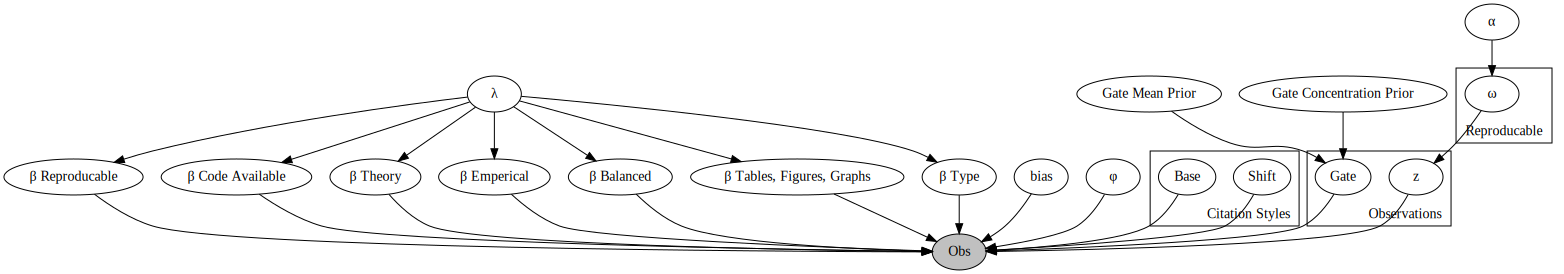

In [30]:
plate_ml.render(filename="plate_ml", format="png")
plate_ml.render(filename="plate_ml", format="pdf")
plate_ml.render(filename="plate_ml", format="dot")
plate_ml

In [31]:
#Now that we have rendered the model, we can transform the coefficients that are hierarchical  so that they converge in fewer samples
ops = ['β Reproducable', 'β Code Available', 'β Theory', 'β Emperical', 'β Balanced', 'β Tables, Figures, Graphs', 'β Type',]
config = dict(zip([i for i in ops], [LocScaleReparam(0) for _ in ops]))
model = numpyro.handlers.reparam(model, config=config)

In [32]:
SEED = 1337
args = {'algo': 'NUTS', 'num_warmup': 500, 'num_samples':2250, 'num_chains':1, 'thinning':3}
rng_key, rng_key_predict = random.split(random.PRNGKey(SEED))

max_tree_depth = 10
#This try catch will let you switch between enabling/disabling the discrete Z latents if you want to mess with the model. 
try:
  kernel = DiscreteHMCGibbs(NUTS(model, max_tree_depth=max_tree_depth, dense_mass=False), modified=True)
  mcmc = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc.run(rng_key, max_clusters, reproduced, year_published, code_available, theory, empirical, balanced, tfpg, types, topic, citation_count)
except AssertionError:
  kernel = NUTS(model, max_tree_depth=max_tree_depth)
  mcmc = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc.run(rng_key, max_clusters, reproduced, year_published, code_available, theory, empirical, balanced, tfpg, types, topic, citation_count)



sample: 100%|██████████| 2750/2750 [1:57:11<00:00,  2.56s/it, 127 steps of size 2.16e-02. acc. prob=0.85]


In [33]:
mcmc.print_summary(exclude_deterministic=False)


                                             mean       std    median      5.0%     95.0%     n_eff     r_hat
                                Base[0]      2.85      0.08      2.85      2.71      2.97    392.85      1.00
                                Base[1]      0.99      0.11      0.98      0.80      1.18    121.42      1.00
                                Base[2]      1.01      0.11      1.01      0.84      1.19    155.21      1.00
                                Base[3]      0.87      0.17      0.90      0.64      1.11      4.00      1.87
                                Base[4]      0.99      0.10      0.99      0.83      1.16    225.03      1.00
                                Base[5]      1.01      0.11      1.00      0.83      1.20    177.86      1.01
                                Base[6]      1.01      0.10      1.00      0.82      1.16    332.34      1.00
                                Base[7]      0.91      0.18      0.96      0.64      1.14      5.14      1.39
         

Lets get data from the model for results!

In [34]:
states = mcmc._states[mcmc._sample_field]
summary = numpyro.diagnostics.summary(states)
samples = mcmc.get_samples()

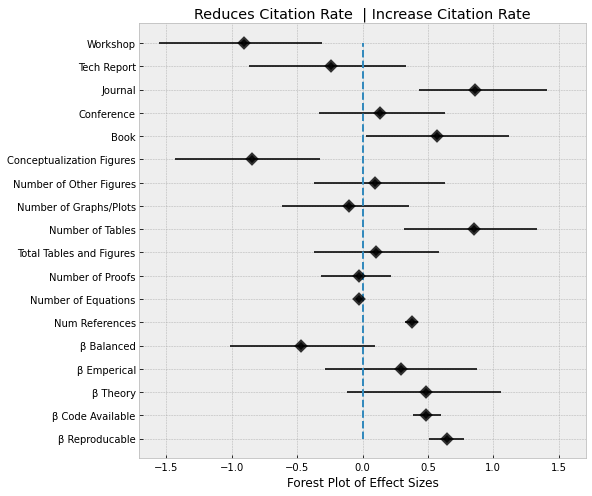

In [35]:
to_plot = ['β Reproducable', 'β Code Available', 'β Theory', 'β Emperical', 'β Balanced']
grouped_plot = [('β Tables, Figures, Graphs', [ 'Num References', 'Number of Equations',
       'Number of Proofs', 'Total Tables and Figures',
       'Number of Tables', 'Number of Graphs/Plots',
       'Number of Other Figures',
       'Conceptualization Figures']),
       ('β Type', all_types)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

mean_es = jnp.array([summary[x]['mean'] for x in to_plot])
low_es = jnp.array([summary[x]['5.0%'] for x in to_plot])
high_es = jnp.array([summary[x]['95.0%'] for x in to_plot])

mean_es = jnp.hstack([mean_es] + [summary[x]['mean'] for x, _ in grouped_plot] )
low_es = jnp.hstack([low_es] + [summary[x]['5.0%'] for x, _ in grouped_plot] )
high_es = jnp.hstack([high_es] + [summary[x]['95.0%'] for x, _ in grouped_plot] )
for key, names in grouped_plot:
  to_plot.extend(names)

ax.plot(jnp.ones(len(mean_es))*0.0, jnp.arange(len(to_plot)), "--")
ax.errorbar(
    x=mean_es,
    y=jnp.arange(len(to_plot)),
    xerr=jnp.stack([mean_es - low_es, high_es - mean_es]),
    marker="D",
    ms=5,
    mew=4,
    ls="none",
    color='black',
    alpha=0.8,
)
#Make x-axis symetrix
x_lim = np.max(np.abs(ax.get_xlim()))
ax.set_xlim((-x_lim, x_lim))
ax.set_yticks(jnp.arange(len(to_plot)))
ax.set_yticklabels(to_plot)
ax.set(
    xlabel="Forest Plot of Effect Sizes",
    title="Reduces Citation Rate  |" + \
          " Increase Citation Rate"
)
plt.savefig('ml_forest.png',bbox_inches='tight', dpi=300)
plt.savefig('ml_forest.pdf',bbox_inches='tight')
tikzplotlib.save("ml_forest.tex")

## Different citation styles between reproduction and non? 

In [36]:
ω = summary['ω']['mean']
ω_low = summary['ω']['5.0%']
ω_high = summary['ω']['95.0%']
frac_repo = reproduced.sum()/reproduced.shape[0]
ω_avg = ω[1,:]*frac_repo +  ω[0,:]*(1-frac_repo)
worth_looking_at = np.max(ω, axis=0) > 1/ω.shape[-1]
print(worth_looking_at.sum())

15


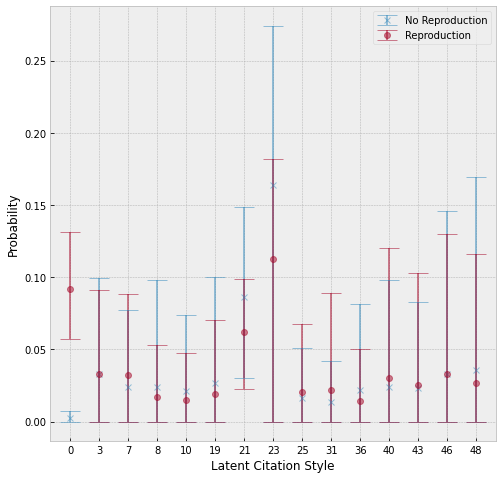

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
for i, marker, label in [(0, 'x', 'No Reproduction'), (1, 'o', 'Reproduction')]:
  ax.errorbar(x=[str(x) for x in np.arange(ω.shape[1])[worth_looking_at]], 
              y=ω[i,:][worth_looking_at], 
              yerr=jnp.stack([ω[i,:]-ω_low[i,:], ω_high[i,:]-ω[i,:]])[:,worth_looking_at], 
              marker=marker, linestyle="None", label=label, alpha=0.5, capsize=10)
ax.set_ylabel("Probability")
ax.set_xlabel("Latent Citation Style")
ax.legend()
plt.savefig('ml_citation_styles.png',bbox_inches='tight', dpi=300)
plt.savefig('ml_citation_styles.pdf',bbox_inches='tight')
tikzplotlib.save("ml_citation_styles.tex")

First lets plot everything on a linear scale, this will be hard to read though because of the few run-away success papers. 

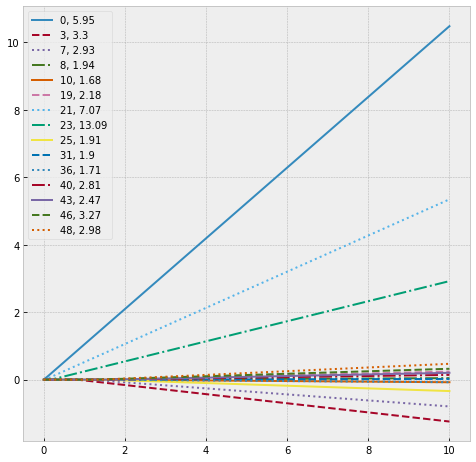

In [38]:
shift = summary['Shift']['mean']
base = jnp.log(summary['Base']['mean'])


steps = 100
x = jnp.linspace(0, 10.0, num=steps)
Y = (base.reshape(-1, 1)*jnp.maximum(x.reshape(1,-1)-shift.reshape(-1,1), 0))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

# print(x)
pos = 0
for i in range(max_clusters):
  if worth_looking_at[i]:
    sns.lineplot(x=x, y=Y[i,:], ax=ax,  linestyle=linestyles[pos % len(linestyles)], label=str(i) + ", " + str(round(ω_avg[i]*100, 2)) + "")
    pos += 1
ax.legend()
plt.savefig('ml_citation_styles_shapes.png',bbox_inches='tight', dpi=300)
plt.savefig('ml_citation_styles_shapes.pdf',bbox_inches='tight')
tikzplotlib.save("ml_citation_styles_shapes.tex")

Again, but symlog so that we can see what is happening more easily. Matplotlib puts the caption in annoying places, I found it easier to move the caption in LaTeX to read it. 

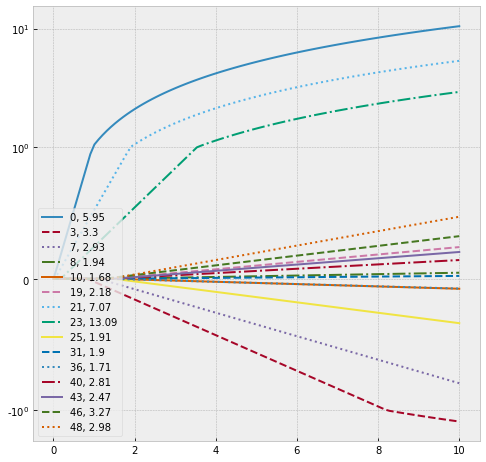

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.set_yscale("symlog", linthreshy=1.0)
# print(x)
pos = 0
for i in range(max_clusters):
  if worth_looking_at[i]:
    sns.lineplot(x=x, y=Y[i,:], ax=ax, linestyle=linestyles[pos % len(linestyles)], label=str(i) + ", " + str(round(ω_avg[i]*100, 2)) + "")
    pos += 1
ax.legend(loc = 'lower left')
plt.savefig('ml_citation_styles_shapes_symlog.png',bbox_inches='tight', dpi=300)
plt.savefig('ml_citation_styles_shapes_symlog.pdf',bbox_inches='tight')
tikzplotlib.save("ml_citation_styles_shapes_symlog.tex")

## Model Fit

In [40]:
posterior_samples = mcmc.get_samples()
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_, max_clusters, reproduced, year_published, code_available, theory, empirical, balanced, tfpg, types, topic, None
)
rng_key, rng_key_ = random.split(rng_key)
prior = Predictive(model, num_samples=500)(
    rng_key_, max_clusters, reproduced, year_published, code_available, theory, empirical, balanced, tfpg, types, topic, None
)
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
)

In [41]:
y_true = numpyro_data.observed_data["Obs"].values
y_pred = numpyro_data.posterior_predictive.stack(sample=("chain", "draw"))["Obs"].values.T
az.r2_score(y_true, y_pred.mean(axis=0).T)

r2        0.298872
r2_std    0.323456
dtype: float64

# Simple Models like Poisson 

In [42]:
m = sm.Poisson(citation_count.sum(axis=-1), reproduced, )
poisson_repo = m.fit_regularized(cov_type='HC3')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3970.6620710190014
            Iterations: 7
            Function evaluations: 10
            Gradient evaluations: 7


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:992: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))


In [43]:
poisson_repo.df_resid

252.0

A normal linear poisson is a bad fit b/c overdispersion https://towardsdatascience.com/adjust-for-overdispersion-in-poisson-regression-4b1f52baa2f1 

In [44]:
print("Mean", citation_count.sum(axis=-1).mean())
print("Variance" , citation_count.sum(axis=-1).std()**2)
print("Overdispersion" , np.square(poisson_repo.resid_pearson).sum()/poisson_repo.df_resid)

Mean 1739.5652173913043
Variance 61969526.767485805
Overdispersion 272598.9110303967


In [45]:
poisson_repo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  253
Model:                        Poisson   Df Residuals:                      252
Method:                           MLE   Df Model:                            0
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                -0.05328
Time:                        05:15:49   Log-Likelihood:            -1.0046e+06
converged:                       True   LL-Null:                   -9.5376e+05
Covariance Type:                  HC3   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.8332      0.303     25.842      0.000       7.239       8.427
==============================================================================
"""

In [46]:
m = sm.NegativeBinomial(citation_count.sum(axis=-1), reproduced,)
nb_repo = m.fit_regularized()
nb_repo.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 11.00942637849534
            Iterations: 25
            Function evaluations: 34
            Gradient evaluations: 25


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:992: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  253
Model:               NegativeBinomial   Df Residuals:                      252
Method:                           MLE   Df Model:                            0
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                 -0.4354
Time:                        05:15:49   Log-Likelihood:                -2785.4
converged:                       True   LL-Null:                       -1940.5
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.8332      0.897      8.732      0.000       6.075       9.591
alpha        130.3671      8.376     15.565      0.000     113.951     146.783
==============================================================================
"""

In [47]:
m = sm.Poisson(citation_count.sum(axis=-1), reproduced, )
poisson_repo = m.fit_regularized(cov_type='HC3')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3970.6620710190014
            Iterations: 7
            Function evaluations: 10
            Gradient evaluations: 7


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:992: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))


# Science, Econ, Psych, and Med Version

Again, but not hierarchical over the field of study. 



In [77]:
#Merge all the data frames together
df2 = df_econ.merge(df_psych, how='outer').merge(df_soci, how='outer').merge(df_med, how='outer')
citation_count2 = df2[["0_YearsLater","1_YearsLater", "2_YearsLater", "3_YearsLater", "4_YearsLater", "5_YearsLater", "6_YearsLater", "7_YearsLater", "8_YearsLater", "9_YearsLater"]].to_numpy()
citation_count2_trunk = citation_count2[:,0:6] #We only have 6 years for all samlples
citation_countGS = df2['GS Cites'].to_numpy()
year2 = df2['Year'].to_numpy()
df2['Total Citations'] = citation_count2_trunk.sum(axis=-1)
journal = df2['Journal']
journal_options = journal.unique().tolist()
journal = journal.apply(lambda x: journal_options.index(x)).to_numpy()
field = df2['Field']
field_options = field.unique().tolist()
field = field.apply(lambda x: field_options.index(x)).to_numpy()
reproduced2 = df2['Replicated'].to_numpy()
df2['Replicated'] = df2['Replicated'].apply(lambda x: ['No', 'Yes'][x])

In [78]:
citation_countGS2 = df2[[f"GS_{y}_YearsLater" for y in range(8)]].to_numpy() #Look I got better are writing my code! </ugly prototype code slowly improves>

Are the google scholar and semantic scholar citaitons correlated? Yes, they are! 

In [79]:
rs = []
ps = []
for y in range(8):
  y = str(y)
  valid = ~np.isnan(df2[f'GS_{y}_YearsLater'].to_numpy())
  df2['0_YearsLater'].to_numpy()[valid], df2[f'GS_{y}_YearsLater'].to_numpy()[valid]
  r, p = scipy.stats.pearsonr(df2[f'{y}_YearsLater'].to_numpy()[valid], df2[f'GS_{y}_YearsLater'].to_numpy()[valid])
  rs.append(r)
  ps.append(p*8)
print("Pearson")
print(rs)
print(ps)

Pearson
[0.7447260788124388, 0.8954058003831814, 0.9005417432391989, 0.8628314100903862, 0.8983553314300697, 0.9164083066431671, 0.8962944112597323, 0.8612543345660336]
[6.304707125078494e-25, 4.3849017385983776e-49, 1.6678180230311866e-50, 1.61331390420553e-41, 6.852353911791214e-50, 1.9579393440168084e-55, 2.521494177755018e-49, 3.337238358419589e-41]


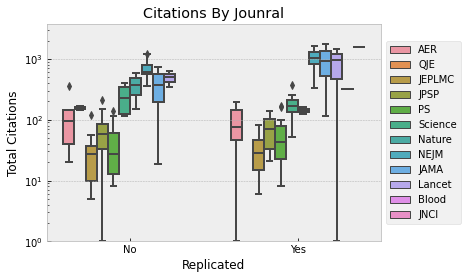

In [81]:
ax = sns.boxplot(data=df2.replace(0, 1).replace(-6, 1), y='Total Citations', x='Replicated', hue='Journal')
ax.set_yscale("log")
lo, hi = ax.get_ylim()
ax.set_ylim(1.0, hi*1.5)
ax.set_title("Citations By Jounral")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('sci_cites_journal.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_cites_journal.pdf',bbox_inches='tight')
tikzplotlib.save("sci_cites_journal.tex")

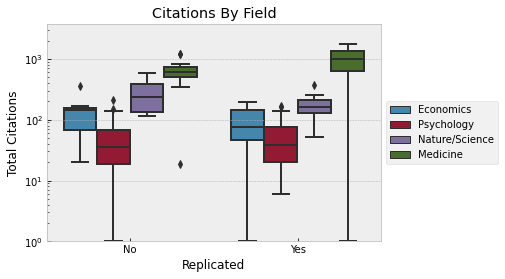

In [82]:
ax = sns.boxplot(data=df2.replace(0, 1).replace(-6, 1), y='Total Citations', x='Replicated', hue='Field')
ax.set_yscale("log")
lo, hi = ax.get_ylim()
ax.set_ylim(1.0, hi*1.5)
ax.set_title("Citations By Field")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('sci_cites_field.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_cites_field.pdf',bbox_inches='tight')
tikzplotlib.save("sci_cites_field.tex")

Text(0.5, 1.0, 'Citations By Field')

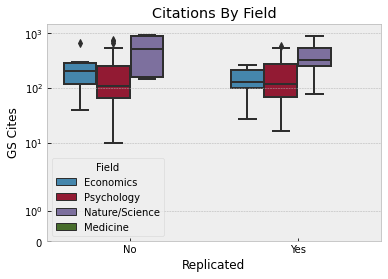

In [83]:
ax = sns.boxplot(data=df2, y='GS Cites', x='Replicated', hue='Field')
ax.set_yscale("symlog")
lo, hi = ax.get_ylim()
ax.set_ylim(0, hi*1.5)
ax.set_title("Citations By Field")

## Simple Linear Models

A bunch of poisson and NB models, all either return no significant relationship or say that reproducible papers are more cited overall. 

In [84]:
valid = citation_count2_trunk.sum(axis=-1) >= 0
m = sm.Poisson(citation_count2_trunk.sum(axis=-1)[valid], np.vstack([reproduced2,np.ones_like(reproduced2)]).T[valid,:] )
poisson_repo2 = m.fit()
poisson_repo2.summary()

Optimization terminated successfully.
         Current function value: 195.161214
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  172
Model:                        Poisson   Df Residuals:                      170
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                 0.04726
Time:                        14:12:32   Log-Likelihood:                -33568.
converged:                       True   LL-Null:                       -35233.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5896      0.010     56.605      0.000       0.569       0.610
const          5.1096      0.008    616.823      0.000       5.093       5.126
==============================================================================
"""

In [85]:
valid = jnp.logical_and(~np.isnan(citation_countGS), citation_countGS >= 0)
m = sm.Poisson(citation_count2_trunk.sum(axis=-1)[valid], np.vstack([reproduced2,np.ones_like(reproduced2)]).T[valid,:] )
poisson_repo2 = m.fit()
poisson_repo2.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 4


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:3390: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.llf/self.llnull
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:3397: RuntimeWarning: invalid value encountered in double_scalars
  return -2*(self.llnull - self.llf)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:                        Poisson   Df Residuals:                      137
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                     nan
Time:                        14:12:37   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                          -inf
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1138      0.019      6.050      0.000       0.077       0.151
const          4.3443      0.013    328.019      0.000       4.318       4.370
==============================================================================
"""

In [86]:
valid = ~np.isnan(citation_countGS)
m = sm.Poisson(citation_countGS[valid], np.vstack([reproduced2,np.ones_like(reproduced2)]).T[valid,:] )
m.exog_names[:] = ['Reproduced'] + m.exog_names[-1:]
poisson_repo2 = m.fit()
poisson_repo2.summary()

Optimization terminated successfully.
         Current function value: 87.022888
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:                        Poisson   Df Residuals:                      137
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:               9.499e-05
Time:                        14:12:37   Log-Likelihood:                -12096.
converged:                       True   LL-Null:                       -12097.
Covariance Type:            nonrobust   LLR p-value:                    0.1295
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Reproduced     0.0172      0.011      1.516      0.129      -0.005       0.039
const          5.4067      0.008    694.404      0.000       5.391       5.422
==============================================================================
"""

In [87]:
m = sm.Poisson(citation_countGS[valid], reproduced2[valid] )
poisson_repo2 = m.fit()
poisson_repo2.summary()

         Current function value: 89994775780117051872302953543425871802625740270358794116272164480145622519028645888.000000
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:                        Poisson   Df Residuals:                      138
Method:                           MLE   Df Model:                            0
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:              -1.034e+81
Time:                        14:12:37   Log-Likelihood:            -1.2509e+85
converged:                      False   LL-Null:                       -12097.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           191.7692   2.83e-43   6.78e+44      0.000     191.769     191.769
==============================================================================
"""

In [88]:
valid = ~np.isnan(citation_countGS)
m = sm.NegativeBinomial(citation_countGS[valid], np.vstack([reproduced2,np.ones_like(reproduced2)]).T[valid,:] )
poisson_repo2 = m.fit()
poisson_repo2.summary()

Optimization terminated successfully.
         Current function value: 6.398046
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               NegativeBinomial   Df Residuals:                      137
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:               7.402e-06
Time:                        14:12:37   Log-Likelihood:                -889.33
converged:                       True   LL-Null:                       -889.33
Covariance Type:            nonrobust   LLR p-value:                    0.9087
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0172      0.150      0.115      0.909      -0.276       0.311
const          5.4067      0.102     52.780      0.000       5.206       5.608
alpha          0.7721      0.084      9.176      0.000       0.607       0.937
==============================================================================
"""

In [89]:
valid = ~np.isnan(citation_countGS)
m = sm.NegativeBinomial(np.maximum(citation_count2_trunk.sum(axis=-1), 0)[valid], np.vstack([reproduced2,np.ones_like(reproduced2)]).T[valid,:] )
poisson_repo2 = m.fit()
poisson_repo2.summary()

Optimization terminated successfully.
         Current function value: 5.401677
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               NegativeBinomial   Df Residuals:                      137
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:               0.0003291
Time:                        14:12:37   Log-Likelihood:                -750.83
converged:                       True   LL-Null:                       -751.08
Covariance Type:            nonrobust   LLR p-value:                    0.4820
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1148      0.163      0.703      0.482      -0.205       0.435
const          4.3443      0.112     38.876      0.000       4.125       4.563
alpha          0.9111      0.101      9.035      0.000       0.713       1.109
==============================================================================
"""

In [90]:
m = sm.NegativeBinomial(np.maximum(citation_count2_trunk.sum(axis=-1), 0)[valid], reproduced2[valid] )
poisson_repo2 = m.fit_regularized(cov_type='HC3')
poisson_repo2.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.572390686322581
            Iterations: 20
            Function evaluations: 27
            Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               NegativeBinomial   Df Residuals:                      138
Method:                           MLE   Df Model:                            0
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                 -0.5865
Time:                        14:12:37   Log-Likelihood:                -1191.6
converged:                       True   LL-Null:                       -751.08
Covariance Type:                  HC3   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.4592      0.108     41.468      0.000       4.248       4.670
alpha         41.5601      6.904      6.020      0.000      28.028      55.092
==============================================================================
"""

In [91]:
m = sm.NegativeBinomial(np.maximum(citation_count2_trunk.sum(axis=-1), 0), np.hstack([reproduced2.reshape(-1, 1), np.ones_like(reproduced2).reshape(-1, 1)]) )
m.exog_names[:] = ['Reproduced'] + m.exog_names[-2:]
nb_repo2 = m.fit() 
nb_repo2.summary()

Optimization terminated successfully.
         Current function value: 6.285411
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                  173
Model:               NegativeBinomial   Df Residuals:                      171
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Apr 2022   Pseudo R-squ.:                0.003784
Time:                        14:12:37   Log-Likelihood:                -1087.4
converged:                       True   LL-Null:                       -1091.5
Covariance Type:            nonrobust   LLR p-value:                  0.004050
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Reproduced     0.5777      0.198      2.914      0.004       0.189       0.966
const          5.1096      0.139     36.754      0.000       4.837       5.382
alpha          1.6947      0.155     10.902      0.000       1.390       1.999
==============================================================================
"""

In [97]:
#Again, very over-dispersed. 
print("Mean", citation_count2.sum(axis=-1).mean())
print("Variance", citation_count2.sum(axis=-1).std()**2)

Mean 438.35260115606934
Variance 504639.75428514136


In [98]:
def modelSEP(max_clusters, reproduced, year_published, types, field, citation_count, years_out=None):
  eps = 0.001
  λ_ridge = numpyro.sample('Ridge Penalty', dist.HalfCauchy(scale=1))

  n_observations = reproduced.shape[0]
  n_types = np.max(types)+1
  if years_out is None:
    years_out = citation_count.shape[1]
  

  too_soon_mask = jnp.repeat(year_published.reshape(-1,1), years_out, axis=-1) + jnp.repeat(jnp.arange(years_out).reshape(1,-1), year_published.shape[0], axis=0) > 2020
  if citation_count is not None:
    too_soon_mask = jnp.logical_or(too_soon_mask, citation_count < 0)

  α = sample("α", dist.Beta(1,10))
  with numpyro.plate('Reproducable', 2):
    ω = sample("ω", dist.Dirichlet(jnp.ones(max_clusters)*α)) #DP over paper citation rates
  
  t = jnp.arange(0, years_out)
  with numpyro.plate('Citation Styles', max_clusters):
    shift = sample("Shift", dist.LeftTruncatedDistribution(dist.Laplace(0, years_out/6), low=0.0))
    base = jnp.log(sample("Base", dist.Gamma(100, 100)))
  citation_pattern = base.reshape(-1, 1) * jnp.maximum(t.reshape(1,-1)-shift.reshape(-1, 1), 0)

  

  β_repro_prior = sample("β Reproducable Prior", dist.Normal(0, 1))

  gate_mean = sample("Gate Mean Prior", dist.Uniform(0+eps,1-eps))
  gate_concentration = sample("Gate Concentration Prior", dist.Gamma(1, 20))
  with numpyro.plate('Field', field.max()+1):
    β_repro = sample("β Reproducable", dist.Normal(β_repro_prior, λ_ridge))
    bias = sample("bias", dist.Cauchy(0, 1))
  with numpyro.plate('Observations', n_observations):
    Z = numpyro.sample("z", dist.Categorical(probs=ω[reproduced])) 
    gate = sample("Gate", dist.BetaProportion(gate_mean, gate_concentration))

  φ = sample("φ", dist.HalfCauchy(5))

  log_mean = β_repro[field] * reproduced + bias[field]
  log_mean = jnp.repeat(jnp.expand_dims(log_mean, -1), years_out, axis=1) #jnp.hstack([jnp.expand_dims(base_citation_rate, -1)]*years_out)

  log_mean += jnp.take(citation_pattern, Z, axis=0) # jnp.stack([citation_pattern[z,:] for z in Z])
  final_gate = jnp.repeat(jnp.expand_dims(gate, -1), years_out, axis=1)

  #Force points in time that have not occured to get zero preds
  final_gate = jnp.maximum(final_gate, too_soon_mask*0.9999)

  
  obs = None
  if citation_count is not None:
    obs = jnp.where(too_soon_mask, jnp.zeros_like(citation_count), citation_count)
  sample('Obs', dist.ZeroInflatedNegativeBinomial2(mean=jnp.exp(log_mean), concentration=1.0/(φ+1e-7), gate=final_gate), obs=obs) 
  return

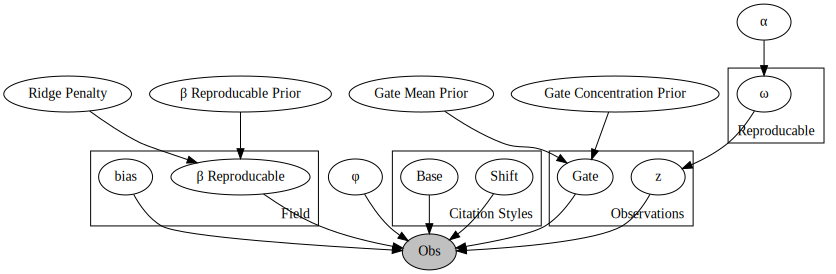

In [99]:
plate_sci = numpyro.render_model(modelSEP, model_args=(max_clusters, reproduced2[0:3], year2[0:3], journal[0:3], field[0:3],  citation_count2[0:3,:]))
plate_sci.render(filename="plate_sci", format="png")
plate_sci.render(filename="plate_sci", format="pdf")
plate_sci.render(filename="plate_sci", format="dot")
plate_sci

In [100]:
# # LocScaleReparam with centered=0 fully "decenters" the prior over betas.
ops = ['β Reproducable']
config = dict(zip([i for i in ops], [LocScaleReparam(0) for _ in ops]))
modelSEP = numpyro.handlers.reparam(modelSEP, config=config)

In [101]:
SEED = 1337
args = {'algo': 'NUTS', 'num_warmup': 500, 'num_samples':2250, 'num_chains':1, 'thinning':3}
rng_key, rng_key_predict = random.split(random.PRNGKey(SEED))

max_tree_depth = 10

try:
  kernel = DiscreteHMCGibbs(NUTS(modelSEP, max_tree_depth=max_tree_depth), modified=True)
  mcmc2 = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc2.run(rng_key, max_clusters, reproduced2, year2, journal, field, citation_count2)
except AssertionError:
  kernel = NUTS(modelSEP, max_tree_depth=max_tree_depth)
  mcmc2 = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc2.run(rng_key, max_clusters, reproduced2, year2, journal, field,  citation_count2)

sample: 100%|██████████| 2750/2750 [47:59<00:00,  1.05s/it, 127 steps of size 2.72e-02. acc. prob=0.84]


In [102]:
mcmc2.print_summary()


                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     Base[0]      0.99      0.10      0.99      0.83      1.15    179.23      1.02
                     Base[1]      1.00      0.10      1.00      0.84      1.15    342.92      1.00
                     Base[2]      0.99      0.10      0.99      0.81      1.13    191.50      1.01
                     Base[3]      0.99      0.10      1.00      0.84      1.16    216.50      1.00
                     Base[4]      0.99      0.10      0.98      0.83      1.14    206.90      1.00
                     Base[5]      1.02      0.11      1.02      0.89      1.25     28.52      1.04
                     Base[6]      1.00      0.10      1.00      0.85      1.17    245.64      1.01
                     Base[7]      1.01      0.10      1.02      0.84      1.15    259.66      1.01
                     Base[8]      1.03      0.13      1.01      0.79      1.20     17.11      1.00
         

In [103]:
states2 = mcmc2._states[mcmc2._sample_field]
summary2 = numpyro.diagnostics.summary(states2)
samples2 = mcmc2.get_samples()

In [106]:
posterior_samples2 = mcmc2.get_samples()
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive2 = Predictive(modelSEP, posterior_samples2)(
    rng_key_, max_clusters, reproduced2, year2, journal, field, None, years_out=10
)
rng_key, rng_key_ = random.split(rng_key)
prior2 = Predictive(modelSEP, num_samples=500)(
    rng_key_, max_clusters, reproduced2, year2, journal, field, None, years_out=10
)
numpyro_data2 = az.from_numpyro(
    mcmc2,
    prior=prior2,
    posterior_predictive=posterior_predictive2,
)

y_true = numpyro_data2.observed_data["Obs"].values
y_pred = numpyro_data2.posterior_predictive.stack(sample=("chain", "draw"))["Obs"].values.T
az.r2_score(y_true, y_pred.mean(axis=0).T)

r2        0.249294
r2_std    0.130306
dtype: float64

In [107]:
y_true = numpyro_data2.observed_data["Obs"].values
y_pred = numpyro_data2.posterior_predictive.stack(sample=("chain", "draw"))["Obs"].values.T
az.r2_score(y_true, y_pred.mean(axis=0).T)

r2        0.249294
r2_std    0.130306
dtype: float64

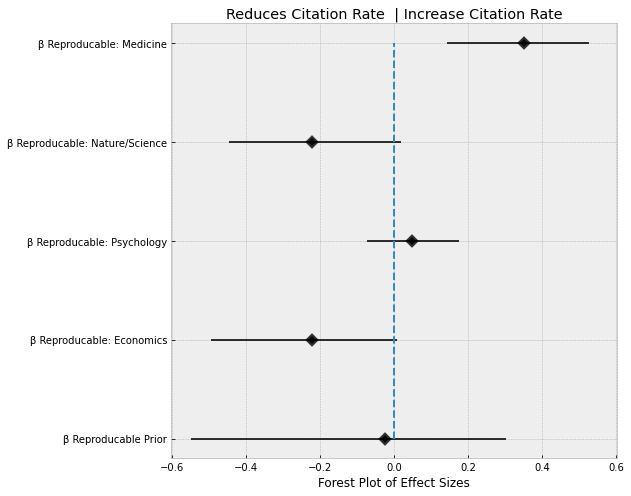

In [108]:
to_plot = ['β Reproducable Prior', ]
grouped_plot = [
                ('β Reproducable', ['β Reproducable: ' + f for f in field_options])
                ]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

mean_es = jnp.array([summary2[x]['mean'] for x in to_plot])
low_es = jnp.array([summary2[x]['5.0%'] for x in to_plot])
high_es = jnp.array([summary2[x]['95.0%'] for x in to_plot])

mean_es = jnp.hstack([mean_es] + [summary2[x]['mean'] for x, _ in grouped_plot] )
low_es = jnp.hstack([low_es] + [summary2[x]['5.0%'] for x, _ in grouped_plot] )
high_es = jnp.hstack([high_es] + [summary2[x]['95.0%'] for x, _ in grouped_plot] )
for key, names in grouped_plot:
  to_plot.extend(names)

ax.plot(jnp.ones(len(mean_es))*0.0, jnp.arange(len(to_plot)), "--")
ax.errorbar(
    x=mean_es,
    y=jnp.arange(len(to_plot)),
    xerr=jnp.stack([mean_es - low_es, high_es - mean_es]),
    marker="D",
    ms=5,
    mew=4,
    ls="none",
    color='black',
    alpha=0.8,
)
#Make x-axis symetrix
x_lim = np.max(np.abs(ax.get_xlim()))
ax.set_xlim((-x_lim, x_lim))
ax.set_yticks(jnp.arange(len(to_plot)))
ax.set_yticklabels(to_plot)
ax.set(
    # xlabel="Multiplicative Effect on Citation Rate",
    # ylabel="Type",
    xlabel="Forest Plot of Effect Sizes",
    title="Reduces Citation Rate  |" + \
          " Increase Citation Rate"
)
plt.savefig('sci_forest.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_forest.pdf',bbox_inches='tight')
tikzplotlib.save("sci_forest.tex")

In [109]:
ω2 = summary2['ω']['mean']
ω2_low = summary2['ω']['5.0%']
ω2_high = summary2['ω']['95.0%']
frac_repo = reproduced2.sum()/reproduced2.shape[0]
ω2_avg = ω2[1,:]*frac_repo +  ω2[0,:]*(1-frac_repo)
worth_looking_at = np.max(ω2, axis=0) > 1.0/ω2.shape[-1]
print(worth_looking_at.sum())

24


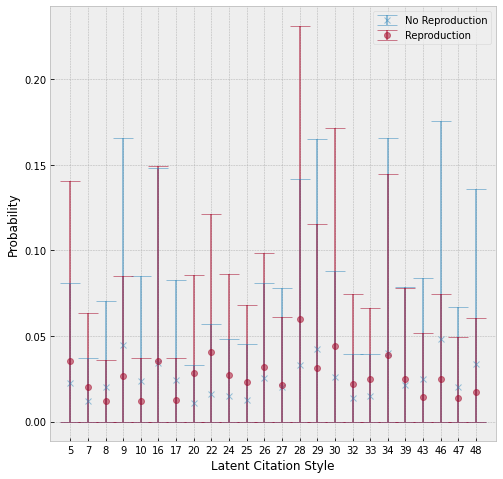

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
for i, marker, label in [(0, 'x', 'No Reproduction'), (1, 'o', 'Reproduction')]:
  ax.errorbar(x=[str(x) for x in np.arange(ω2.shape[1])[worth_looking_at]], 
              y=ω2[i,:][worth_looking_at], 
              yerr=jnp.stack([ω2[i,:]-ω2_low[i,:], ω2_high[i,:]-ω2[i,:]])[:,worth_looking_at], 
              marker=marker, linestyle="None", label=label, alpha=0.5, capsize=10)
ax.set_ylabel("Probability")
ax.set_xlabel("Latent Citation Style")
ax.legend()
plt.savefig('sci_style.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_style.pdf',bbox_inches='tight')
tikzplotlib.save("sci_style.tex")

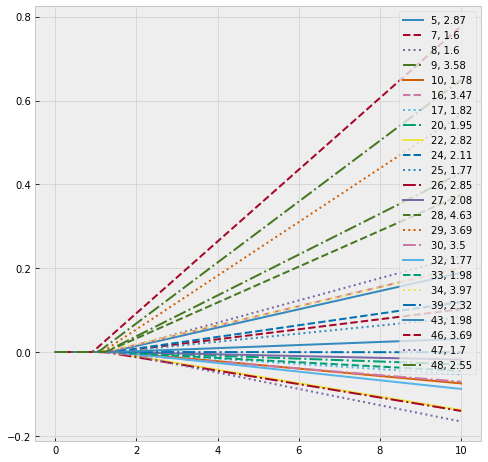

In [114]:
shift = summary2['Shift']['mean']
base = jnp.log(summary2['Base']['mean'])


steps = 100
x = jnp.linspace(0, 10.0, num=steps)
Y = (base.reshape(-1, 1)*jnp.maximum(x.reshape(1,-1)-shift.reshape(-1,1), 0))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

pos = 0
for i in range(max_clusters):
  if worth_looking_at[i]:
    sns.lineplot(x=x, y=Y[i,:], ax=ax, linestyle=linestyles[pos % len(linestyles)], label=str(i) + ", " + str(round(ω2_avg[i]*100, 2)) + "")
    pos += 1
ax.legend()
plt.savefig('sci_citation_styles_shapes.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_citation_styles_shapes.pdf',bbox_inches='tight')
tikzplotlib.save("sci_citation_styles_shapes.tex")

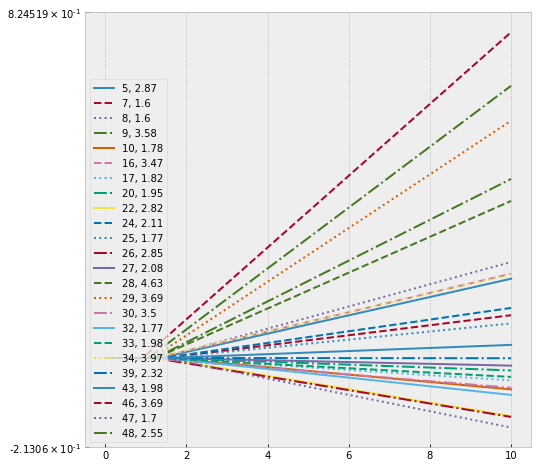

In [115]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.set_yscale("symlog", linthreshy=1.0)
pos = 0
for i in range(max_clusters):
  if worth_looking_at[i]:
    sns.lineplot(x=x, y=Y[i,:], ax=ax, linestyle=linestyles[pos % len(linestyles)], label=str(i) + ", " + str(round(ω2_avg[i]*100, 2)) + "")
    pos += 1
ax.legend(loc = "lower left")
# ax.legend(loc = "best")
plt.savefig('sci_citation_styles_shapes_symlog.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_citation_styles_shapes_symlog.pdf',bbox_inches='tight')
tikzplotlib.save("sci_citation_styles_shapes_symlog.tex")

In [116]:
posterior_samples2 = mcmc2.get_samples()
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive2 = Predictive(modelSEP, posterior_samples2)(
    rng_key_, max_clusters, reproduced2, year2, journal, field, None, 10
)
rng_key, rng_key_ = random.split(rng_key)
prior2 = Predictive(modelSEP, num_samples=500)(
    rng_key_, max_clusters,  reproduced2, year2, journal, field,  None, 10
)
numpyro_data2 = az.from_numpyro(
    mcmc2,
    prior=prior2,
    posterior_predictive=posterior_predictive2,
)

y_true = numpyro_data2.observed_data["Obs"].values
y_pred = numpyro_data2.posterior_predictive.stack(sample=("chain", "draw"))["Obs"].values.T
az.r2_score(y_true, y_pred.mean(axis=0).T)

r2        0.250603
r2_std    0.130493
dtype: float64

## Again but no medicin

In [117]:
SEED = 1337
args = {'algo': 'NUTS', 'num_warmup': 500, 'num_samples':2250, 'num_chains':1, 'thinning':3}
rng_key, rng_key_predict = random.split(random.PRNGKey(SEED))

max_tree_depth = 10

try:
  kernel = DiscreteHMCGibbs(NUTS(modelSEP, max_tree_depth=max_tree_depth), modified=True)
  mcmc2a = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc2a.run(rng_key, max_clusters, reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3], citation_count2[field < 3])
except AssertionError:
  kernel = NUTS(modelSEP, max_tree_depth=max_tree_depth)
  mcmc2a = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc2a.run(rng_key, max_clusters, reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3],  citation_count2[field < 3])

sample: 100%|██████████| 2750/2750 [32:26<00:00,  1.41it/s, 127 steps of size 2.33e-02. acc. prob=0.88]


In [118]:
states2a = mcmc2a._states[mcmc2a._sample_field]
summary2a = numpyro.diagnostics.summary(states2a)
samples2a = mcmc2a.get_samples()

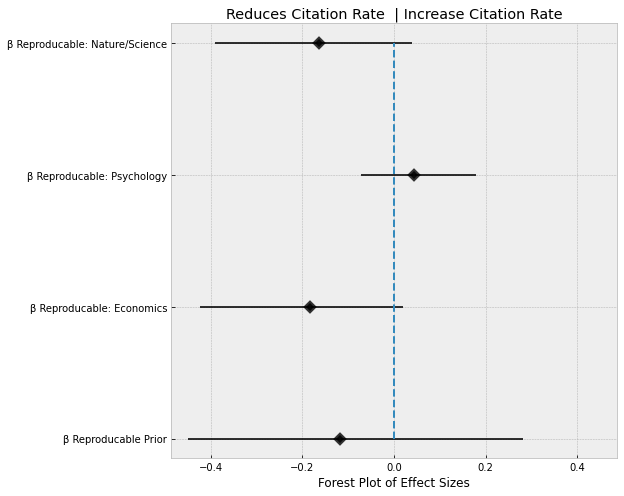

In [119]:
to_plot = ['β Reproducable Prior', ]
grouped_plot = [
                ('β Reproducable', ['β Reproducable: ' + f for f in field_options[0:-1]])
                ]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

mean_es = jnp.array([summary2a[x]['mean'] for x in to_plot])
low_es = jnp.array([summary2a[x]['5.0%'] for x in to_plot])
high_es = jnp.array([summary2a[x]['95.0%'] for x in to_plot])

mean_es = jnp.hstack([mean_es] + [summary2a[x]['mean'] for x, _ in grouped_plot] )
low_es = jnp.hstack([low_es] + [summary2a[x]['5.0%'] for x, _ in grouped_plot] )
high_es = jnp.hstack([high_es] + [summary2a[x]['95.0%'] for x, _ in grouped_plot] )
for key, names in grouped_plot:
  to_plot.extend(names)

ax.plot(jnp.ones(len(mean_es))*0.0, jnp.arange(len(to_plot)), "--")
ax.errorbar(
    x=mean_es,
    y=jnp.arange(len(to_plot)),
    xerr=jnp.stack([mean_es - low_es, high_es - mean_es]),
    marker="D",
    ms=5,
    mew=4,
    ls="none",
    color='black',
    alpha=0.8,
)
#Make x-axis symetrix
x_lim = np.max(np.abs(ax.get_xlim()))
ax.set_xlim((-x_lim, x_lim))
ax.set_yticks(jnp.arange(len(to_plot)))
ax.set_yticklabels(to_plot)
ax.set(
    # xlabel="Multiplicative Effect on Citation Rate",
    # ylabel="Type",
    xlabel="Forest Plot of Effect Sizes",
    title="Reduces Citation Rate  |" + \
          " Increase Citation Rate"
)
plt.savefig('sci_forest_no_med.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_forest_no_med.pdf',bbox_inches='tight')
tikzplotlib.save("sci_forest_no_med.tex")

In [120]:
posterior_samples2 = mcmc2a.get_samples()
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive2 = Predictive(modelSEP, posterior_samples2)(
    rng_key_, max_clusters, reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3], None, 10
)
rng_key, rng_key_ = random.split(rng_key)
prior2 = Predictive(modelSEP, num_samples=500)(
    rng_key_, max_clusters,  reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3],  None, 10
)
numpyro_data2 = az.from_numpyro(
    mcmc2a,
    prior=prior2,
    posterior_predictive=posterior_predictive2,
)

y_true = numpyro_data2.observed_data["Obs"].values
y_pred = numpyro_data2.posterior_predictive.stack(sample=("chain", "draw"))["Obs"].values.T
az.r2_score(y_true, y_pred.mean(axis=0).T)

r2        0.188979
r2_std    0.082516
dtype: float64

## Again Again, but using google scholar citation data instead

In [121]:
SEED = 1337
args = {'algo': 'NUTS', 'num_warmup': 500, 'num_samples':2250, 'num_chains':1, 'thinning':3}
rng_key, rng_key_predict = random.split(random.PRNGKey(SEED))

max_tree_depth = 10

try:
  kernel = DiscreteHMCGibbs(NUTS(modelSEP, max_tree_depth=max_tree_depth), modified=True)
  mcmc2b = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc2b.run(rng_key, max_clusters, reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3], citation_countGS2[field < 3, :])
except AssertionError:
  kernel = NUTS(modelSEP, max_tree_depth=max_tree_depth)
  mcmc2b = MCMC(
    kernel,
    num_warmup=args['num_warmup'],
    num_samples=args['num_samples'],
    num_chains=args['num_chains'],
    thinning=args['thinning'],
    progress_bar=True,
  )
  mcmc2b.run(rng_key, max_clusters, reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3],  citation_countGS2[field < 3, :])

sample: 100%|██████████| 2750/2750 [08:26<00:00,  5.43it/s, 255 steps of size 1.88e-02. acc. prob=0.88]


In [122]:
states2b = mcmc2b._states[mcmc2b._sample_field]
summary2b = numpyro.diagnostics.summary(states2b)
samples2b = mcmc2b.get_samples()

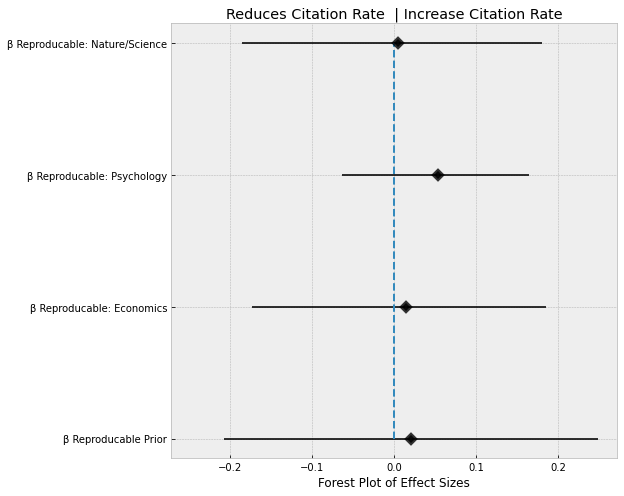

In [123]:
to_plot = ['β Reproducable Prior', ]
grouped_plot = [
                ('β Reproducable', ['β Reproducable: ' + f for f in field_options[0:-1]])
                ]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

mean_es = jnp.array([summary2b[x]['mean'] for x in to_plot])
low_es = jnp.array([summary2b[x]['5.0%'] for x in to_plot])
high_es = jnp.array([summary2b[x]['95.0%'] for x in to_plot])

mean_es = jnp.hstack([mean_es] + [summary2b[x]['mean'] for x, _ in grouped_plot] )
low_es = jnp.hstack([low_es] + [summary2b[x]['5.0%'] for x, _ in grouped_plot] )
high_es = jnp.hstack([high_es] + [summary2b[x]['95.0%'] for x, _ in grouped_plot] )
for key, names in grouped_plot:
  to_plot.extend(names)

ax.plot(jnp.ones(len(mean_es))*0.0, jnp.arange(len(to_plot)), "--")
ax.errorbar(
    x=mean_es,
    y=jnp.arange(len(to_plot)),
    xerr=jnp.stack([mean_es - low_es, high_es - mean_es]),
    marker="D",
    ms=5,
    mew=4,
    ls="none",
    color='black',
    alpha=0.8,
)
#Make x-axis symetrix
x_lim = np.max(np.abs(ax.get_xlim()))
ax.set_xlim((-x_lim, x_lim))
ax.set_yticks(jnp.arange(len(to_plot)))
ax.set_yticklabels(to_plot)
ax.set(
    # xlabel="Multiplicative Effect on Citation Rate",
    # ylabel="Type",
    xlabel="Forest Plot of Effect Sizes",
    title="Reduces Citation Rate  |" + \
          " Increase Citation Rate"
)
plt.savefig('sci_forest_no_med_gs.png',bbox_inches='tight', dpi=300)
plt.savefig('sci_forest_no_med_gs.pdf',bbox_inches='tight')
tikzplotlib.save("sci_forest_no_med_gs.tex")

In [124]:
posterior_samples2 = mcmc2b.get_samples()
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive2 = Predictive(modelSEP, posterior_samples2)(
    rng_key_, max_clusters, reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3], None, 8
)
rng_key, rng_key_ = random.split(rng_key)
prior2 = Predictive(modelSEP, num_samples=500)(
    rng_key_, max_clusters,  reproduced2[field < 3], year2[field < 3], journal[field < 3], field[field < 3],  None, 8
)
numpyro_data2 = az.from_numpyro(
    mcmc2b,
    prior=prior2,
    posterior_predictive=posterior_predictive2,
)

y_true = numpyro_data2.observed_data["Obs"].values
y_pred = numpyro_data2.posterior_predictive.stack(sample=("chain", "draw"))["Obs"].values.T
az.r2_score(y_true, y_pred.mean(axis=0).T)

r2        0.411516
r2_std    0.175045
dtype: float64